In [1]:
import pickle

with open('../../PNC_Good/MegaMeta3.pkl', 'rb') as f: 
    meta = pickle.load(f)
    
print('Complete')

Complete


In [2]:
with open('../../Work/LatentSim/Splits.pkl', 'rb') as f:
    keys, groups = pickle.load(f)
    
print(len(keys))
print(len(groups[0][0])+len(groups[0][1]))
print('Complete')

620
620
Complete


In [3]:
import numpy as np

nback = np.stack([meta[key]['nback'] for key in keys])
emoid = np.stack([meta[key]['emoid'] for key in keys])

print(nback.shape)
print(emoid.shape)

(620, 264, 231)
(620, 264, 210)


In [4]:
from nilearn.connectome import ConnectivityMeasure

def getFC(timeSeries, kind='correlation', transpose=True):
    connMeasure = ConnectivityMeasure(kind=kind)
    if transpose:
        timeSeries = np.transpose(timeSeries, axes=(0,2,1))
    return connMeasure.fit_transform(timeSeries)

nback_p = getFC(nback)
emoid_p = getFC(emoid)

print(nback_p.shape)

(620, 264, 264)


In [5]:
import torch

def convertTorch(p):
    t = torch.from_numpy(p).float()
    u = []
    for i in range(t.shape[0]):
        u.append(t[i][torch.triu_indices(264,264,offset=1).unbind()])
    return torch.stack(u).cuda()

nback_p_t = convertTorch(nback_p)
emoid_p_t = convertTorch(emoid_p)

print(nback_p_t.shape)
print(emoid_p_t.shape)
print('Complete')

torch.Size([620, 34716])
torch.Size([620, 34716])
Complete


In [6]:
mu_nback = torch.mean(nback_p_t, dim=0, keepdim=True)
mu_emoid = torch.mean(emoid_p_t, dim=0, keepdim=True)
std_nback = torch.std(nback_p_t, dim=0, keepdim=True)
std_emoid = torch.std(emoid_p_t, dim=0, keepdim=True)

nback_p_t = (nback_p_t - mu_nback)/std_nback
emoid_p_t = (emoid_p_t - mu_emoid)/std_emoid

print(torch.min(nback_p_t[:,420:422],dim=0))
print(torch.min(emoid_p_t[:,420:422],dim=0))

torch.return_types.min(
values=tensor([-2.2998, -3.0133], device='cuda:0'),
indices=tensor([603, 350], device='cuda:0'))
torch.return_types.min(
values=tensor([-2.7284, -3.0616], device='cuda:0'),
indices=tensor([351,  33], device='cuda:0'))


In [63]:
age = np.stack([meta[key]['AgeInMonths'] for key in keys])
gen = np.stack([np.array([meta[key]['Gender'] == 'M', meta[key]['Gender'] == 'F']) for key in keys]).astype(int)
wrt = np.stack([meta[key]['wratStd'] for key in keys])

print(age.shape)
print(gen.shape)
print(wrt.shape)

age_t = torch.from_numpy(age).float().cuda()
gen_t = torch.from_numpy(gen).float().cuda()
wrt_t = torch.from_numpy(wrt).float().cuda()

mu_age = torch.mean(age_t)
sd_age = torch.std(age_t)

age_t = (age_t - mu_age)

print('Complete')

(620,)
(620, 2)
(620,)
Complete


In [64]:
import torch.nn as nn
import torch.nn.functional as F
import time

ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()

rmse = []
Ass = []
features = []

def allBelowThresh(losses, thresh):
    for loss,thr in zip(losses, thresh):
        if loss > thr:
            return False
    return True

def flatten(res):
    flat = [r for re in res for r in re]
    return flat

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

def arith(n):
    return int(n*(n+1)/2)

def getAvg(res):
    nPara = len(res)
    nTasks = len(res[0])
    avg = []
    for task in range(nTasks):
        avg.append(0)
        for para in range(nPara):
            avg[-1] += res[para][task]/nPara
    return avg

class LatSim(nn.Module):
    def __init__(self, nTasks, inp, dp=0.5, edp=0.1, adp=0.1, wInit=1e-4, dimA=2, dimB=2, temp=1):
        super(LatSim, self).__init__()
        self.nTasks = nTasks
        self.A = nn.Parameter(wInit*torch.randn(2,inp.shape[-1],dimA).float().cuda())
        self.B = nn.Parameter(wInit*torch.randn(2,nTasks,dimA,dimB).float().cuda())
        self.dp = nn.Dropout(p=dp)
        self.edp = nn.Dropout(p=edp)
        self.adp = nn.Dropout(p=adp)
        self.t = temp if isinstance(temp, list) else nTasks*[temp]
    
    def getLatent(self, x, para):
        return x[:,para]@self.A[para]
    
    def getEdges(self, A, para, task):
        e = 1e-10
        z = A@self.B[para, task]
        e = e+z@z.T
        return e
        
    def forward(self, x, ys, testIdcs=None):
        assert self.B.shape[1] == len(ys), "business end targets dim not same as passed"
        x = self.dp(x)
        res = []
        As = []
        es = []
        for para in range(2):
            A = self.getLatent(x, para)
            As.append(self.adp(F.relu(A)))
        for para,A in enumerate(As):
            res.append([])
            es.append([])
            for task,y in enumerate(ys):
                e = self.getEdges(A, para, task)
                if testIdcs is not None:
                    e[:,testIdcs] = 0
                e = mask(e)
                e = self.edp(e)
                e[e == 0] = float('-inf')
                e = F.softmax(e/self.t[task], dim=1)
                res[-1].append(e@y)
                es[-1].append(e)
        return res, As, es

def validate(model, X, ys, testIdcs):
    model.eval()
    losses = []
    with torch.no_grad():
        res, _, _ = model(X, ys, testIdcs)
        # for r,y in zip(res, ys):
        for r,y in zip(getAvg(res), ys):
            if y.dim() == 1:
                loss = mseLoss(r[testIdcs], y[testIdcs]).cpu().numpy()**0.5
                losses.append(loss)
            else:
                corr = (torch.argmax(r, dim=1) == torch.argmax(y, dim=1))[testIdcs]
                loss = torch.sum(corr)/len(testIdcs)
                losses.append(loss)
    model.train()
    return losses

def getAs(model, X, ys):
    model.eval()
    As = None
    with torch.no_grad():
        _, As, _ = model(X, ys)
    model.train()
    return As

def binLoss(w):
    mag = torch.abs(w)
    maxMag = torch.max(mag, keepdim=True, dim=1).values
    p = mag/maxMag
    return -torch.sum(p*torch.log(p+1e-10))

def getFeatures(sim, X, yy, task=0, para=0, testIdcs=None):
    #sim.load_state_dict(torch.load(f'../../Work/LatentSim/sim{task}.pyt'))
    sim.eval()
    allDims = []
    with torch.no_grad():
        y = yy[task][testIdcs]
        if y.dim() == 1:
            y = y.unsqueeze(1)
        for dim in range(sim.A.shape[2]):
            mult = torch.sum((sim.B[para,task,dim,:].detach())**2)/2
            d = torch.cdist(y, y)
            d = d - torch.mean(d)
            m = torch.einsum('ad,d->ad', X[testIdcs,para,:], sim.A[para,:,dim].detach())
            sm = F.relu(torch.sum(m, dim=1))
            smi = sm > 0
            whole = []
            for i0 in range(0,34700,1000):
                i1 = i0+1000
                mm = torch.einsum('ad,a,b->abd', m[:,i0:i1], smi, sm)
                part = torch.einsum('ab,abd->d', d, mm)
                whole.append(part)
            whole = torch.cat(whole)
        allDims.append(mult*whole)
    sim.train()
    return torch.mean(torch.stack(allDims), axis=0)

nEpochs = 1000
pPeriod = 50
thresh = [20,0.3,10]
regParam = [1,1e3,20]
binParam = 0

for rep in range(1):
    for grp in range(1):
        trainIdcs = groups[grp][0][0:496]
        trainValidIdcs = groups[grp][0]
        validIdcs = np.arange(496,len(trainValidIdcs))
        testIdcs = groups[grp][1]

        X0 = nback_p_t
        X1 = emoid_p_t

        X = torch.stack([X0, X1], dim=1)
        Xt = X[trainIdcs]
        Xtv = X[trainValidIdcs]

        yy = [age_t, gen_t, wrt_t]
        yt = [age_t[trainIdcs], gen_t[trainIdcs], wrt_t[trainIdcs]]
        ytv = [age_t[trainValidIdcs], gen_t[trainValidIdcs], wrt_t[trainValidIdcs]]

    #     yy = yy[2:]
    #     yt = yt[2:]
    #     ytv = ytv[2:]

        nTasks = len(yy)

        sim = LatSim(nTasks, X, dp=0.5, edp=0.1, adp=0.3, wInit=1e-4, dimA=20, dimB=2, temp=[1,1,1])
        optim = torch.optim.Adam(sim.parameters(), lr=5e-4, weight_decay=5e-4)

        validLoss = [[] for _ in range(nTasks)]

        for epoch in range(nEpochs):
            optim.zero_grad()
            res, As, _ = sim(Xt, yt)
            loss = []
            for i,(r,y) in enumerate(zip(flatten(res)+getAvg(res), (X.shape[1]+1)*yt)):
                if y.dim() > 1:
                    loss.append(regParam[i%nTasks]*ceLoss(r, y))
                else:
                    loss.append(regParam[i%nTasks]*mseLoss(r, y))
            bloss = [binParam*binLoss(sim.A)]
            loss += bloss
            sum(loss).backward()
            optim.step()
            if epoch % pPeriod == 0 or epoch == nEpochs-1 or allBelowThresh(loss[0:nTasks], thresh):
                print(f'epoch {epoch} loss={bloss}')
                losses = validate(sim, Xtv, ytv, validIdcs)
                for i,lss in enumerate(losses):
                    if (len(validLoss[i]) == 0 or 
                            (yy[i].dim() == 1 and lss < min(validLoss[i])) or 
                            (yy[i].dim() > 1 and lss > max(validLoss[i]))):
                        print(f'New best validation epoch {epoch} {i} loss={lss}')
                        torch.save(sim.state_dict(), f'../../Work/LatentSim/sim{i}.pyt')
                        validLoss[i].append(float(lss))
                if allBelowThresh(loss[0:nTasks], thresh):
                    print('Early stopping')
                    break

        finalLoss = []
        featPart = np.zeros((2,nTasks,34716))

        for task in range(nTasks):
            sim.load_state_dict(torch.load(f'../../Work/LatentSim/sim{task}.pyt'))
            loss = validate(sim, X, yy, testIdcs)
            finalLoss.append(float(loss[task]))

#             for para in range(2):
#                 feat = getFeatures(sim, X, yy, task, para, testIdcs)
#                 featPart[para,task] = feat.detach().cpu().numpy()

        rmse.append(finalLoss)
        features.append(np.stack(featPart))

        print(f'FINISHED {rmse}')

epoch 0 loss=[tensor(0., device='cuda:0', grad_fn=<MulBackward0>)]
New best validation epoch 0 0 loss=44.583885192871094
New best validation epoch 0 1 loss=0.5
New best validation epoch 0 2 loss=12.045475959777832
epoch 50 loss=[tensor(0., device='cuda:0', grad_fn=<MulBackward0>)]
New best validation epoch 50 0 loss=24.979759216308594
New best validation epoch 50 1 loss=0.6290322542190552
New best validation epoch 50 2 loss=11.482730865478516
epoch 100 loss=[tensor(0., device='cuda:0', grad_fn=<MulBackward0>)]
New best validation epoch 100 0 loss=23.18855094909668
New best validation epoch 100 2 loss=11.399859428405762
epoch 150 loss=[tensor(0., device='cuda:0', grad_fn=<MulBackward0>)]
New best validation epoch 150 2 loss=11.394168853759766
epoch 200 loss=[tensor(0., device='cuda:0', grad_fn=<MulBackward0>)]
New best validation epoch 200 1 loss=0.7258064150810242
New best validation epoch 200 2 loss=11.272496223449707
epoch 250 loss=[tensor(0., device='cuda:0', grad_fn=<MulBackward0>)

In [65]:
sim.eval()
with torch.no_grad():
    sim.load_state_dict(torch.load(f'../../Work/LatentSim/sim0.pyt'))
    res, _, esAge = sim(X, yy, testIdcs)
sim.train()

print(len(res))
print(len(esAge))

2
2


In [66]:
age = age_t.detach().cpu().numpy()

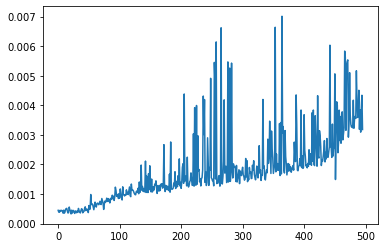

In [80]:
import matplotlib.pyplot as plt

res00 = res[0][0].detach().cpu().numpy()
es00 = esAge[0][0][:,trainIdcs].detach().cpu().numpy()

idcs = np.argsort(age[trainIdcs])

testIdx = 144

plt.plot(es00[testIdx,idcs])
plt.show()

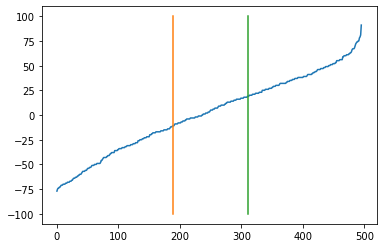

-11.929031
18.073997497558594


In [81]:
ageTrainSorted = age[trainIdcs][idcs]

idx = np.argmax(ageTrainSorted>age[testIdx])
idx2 = np.argmax(ageTrainSorted>float(res[0][0][testIdx]))

plt.plot(ageTrainSorted)
plt.plot([idx,idx],[-100,100])
plt.plot([idx2,idx2],[-100,100])
plt.show()

print(age[testIdx])
print(float(res[0][0][testIdx]))

In [27]:
testIdcs

array([  2,   7,  21,  48,  66,  69,  77,  87, 120, 136, 139, 142, 144,
       150, 155, 165, 166, 172, 173, 179, 187, 195, 200, 210, 225, 228,
       234, 235, 243, 245, 257, 260, 287, 308, 314, 327, 338, 364, 378,
       397, 398, 411, 412, 420, 428, 457, 476, 487, 492, 509, 514, 524,
       543, 551, 581, 589, 590, 599, 601, 606, 612, 616])

In [71]:
age[testIdx]

-33.92903

In [72]:
res[0][0][testIdx]

tensor(6.4440, device='cuda:0')